In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**차원의 저주(curse of dimensionality)** : 많은 특성은 훈련을 느리게 할 뿐만 아니라, 좋은 솔루션을 찾기 어렵게 만듦
+ 차원을 축소
    + 일부 정보가 유실
    + 훈련 속도가 빨라질 수는 있지만 시스템의 성능이 조금 나빠질 수 있음
    + 작업 파이프라인이 조금 더 복잡하게 되고 유지 관리가 어려워짐
    + 일반적으로 훈련 속도만 빨라짐
    + 데이터 시각화에 유용

## 8.1 차원의 저주

훈련 세트의 차원이 클수록 과대적합 위험이 커짐
+ 훈련 샘플의 밀도가 충분히 높아질 때까지 훈련 세트의 크기를 키우는 것은 사실상 불가능

<img src="img/8-1.png" width="500px" align='left'>  

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영(projection)
대부분 훈련 샘플은 모든 차원에 걸쳐 균일하게 퍼져 있지 않음(모든 훈련 샘플이 고차원 공간 안의 저차원 부분 공간에 놓여 있음)
<img src="img/8-2.png" width="400px" align='left'>
<img src="img/8-3.png" width="400px" align='center'>  

left : 모든 훈련 샘플이 거의 평면 형태로 놓여 있음(고차원 공간에 있는 저차원 부분 공간)  
right : 모든 훈련 샘플을 이 부분 공간에 수직으로 투영하면 2D 데이터셋을 얻음

In [2]:
# 스위스롤 데이터셋 생성 코드
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

그림 저장 swiss_roll_plot


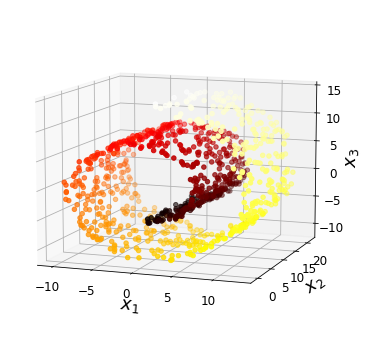

In [3]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

그림 저장 squished_swiss_roll_plot


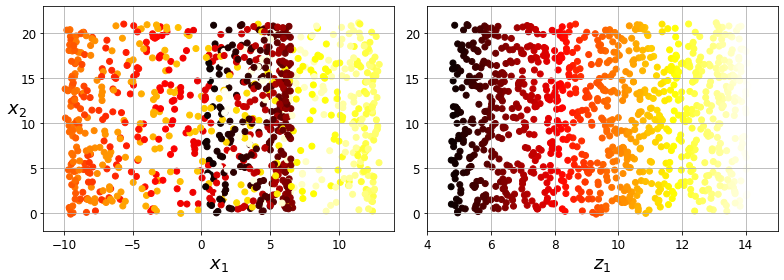

In [4]:
# 평면에 그냥 투영시켜서 뭉개진 것(왼쪽)과 스위스 롤을 펼쳐 놓은 것(오른쪽)> 생성 코드
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

### 8.2.2 매니폴드 학습
스위스롤은 2D 매니폴드의 한 예시(2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양)

**매니폴드(manifold)**
+ 일반적으로 d차원 매니폴드는 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부(d < n)

**매니폴드 학습(manifold learning)** : 훈련 샘플이 놓여 있는 매니폴드를 모델링
+ 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정에 근거
+ 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이라는 가정(but, 항상 유효하지는 않음)
+ 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아님

<img src="img/8-6.png" width="500px" align='left'>

## 8.3 PCA

**주성분 분석(principal component analysis, PCA)** : 가장 인기 있는 차원 축소 알고리즘
+ 데이터에 가장 가까운 초평면을 정의한 다음, 데이터를 이 평면에 투영시킴

### 8.3.1 분산 보존
+ 올바른 초평면을 선택
+ left : 간단한 2D 데이터셋이 세 개의 축과 함께 표현
+ right : 데이터셋이 각 축에 투영된 결과
    + 실선에 투영된 것은 분산을 최대로 보존 / 점선에 투영된 것은 분산을 매우 적게 유지
+ 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실(=원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축)

<img src="img/8-7.png" width="500px" align='left'>

### 8.3.2 주성분
+ PCA는 훈련 세트에서 분산이 최대인 축을 찾음
+ 첫 번째 축에 직교하고 남은 분산을 최대한 보존하는 두 번째 축을 찾음
+ 고차원 데이터셋이라면 PCA는 이전의 두 축에 직교하는 세 번쨰 축을 찾으며 데이터셋에 있는 차원의 수만큼 n번째 축을 찾음

**$i$번째 주성분(principal component, PC)** : $i$번째 축
+ PCA는 주성분 방향을 가리키고 원점에 중앙이 맞춰진 단위 벡터를 찾음
+ PCA가 반환하는 단위 벡터의 방향은 일정하지 않음

**특잇값 분해(singular value decomposition, SVD)** : 표준 행렬 분해 기술(훈련 세트 행렬 $X$를 세 개 행렬의 행렬 곱셈으로 분해)
+ $X = U \sum V^T$ 에서 $V$가 주성분 (SVD 함수로부터 얻은 $V^T$를 전치하여 주성분으로 추출)
+ (m, m) (m, n) (n, n)
+ m : 샘플 개수, n : 특성 개수

In [5]:
# 3D 데이터셋
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

+ PCA는 데이터셋의 평균이 0이라고 가정
+ 사이킷런의 PCA 파이썬 클래스는 이 작업을 대신 처리
+ PCA를 직접 구현하거나 다른 라이브러리를 사용한다면 먼저 데이터를 원점에 맞춰야 함
+ 찾을 수 있는 최대의 주성분 개수 = 특성의 개수 (일반적으로 주성분 개수를 더 적게 설정)

In [6]:
# 원점(평균 0)에 맞추기
X_centered = X - X.mean(axis=0)

# numpy의 svd() 함수를 사용해 훈련 세트의 모든 주성분을 구한 후 처음 두 개의 PC를 정의하는 두 개의 단위 벡터를 추출
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [7]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [8]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

### 8.3.3 d차원으로 투영하기
+ 주성분을 모두 추출해냈다면 처음 $d$개의 주성분으로 정의한 초평면에 투영해 데이터셋의 차원을 $d$차원으로 축소 가능
+ 이 초평면은 분산을 가능한 한 최대로 보존하는 투영임을 보장
* $X_{d-proj} = X W_d$
+ $X_{d-proj}$ : 초평면에 훈련 세트를 투영하고 $d$차원으로 축소된 데이터셋
+ $W_d$ : 행렬 $X$와 $V$의 첫 $d$열로 구성된 행렬

In [9]:
# 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영(내적 이용)
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [10]:
X2D_using_svd = X2D

### 8.3.4 사이킷런 사용하기
+ 사이킷런의 PCA 모델은 SVD 분해 방법을 사용해 구현(자동으로 데이터를 중앙으로 맞춰줌)
+ components_ 속성에 $W^d$의 전치가 담여 있음
+ pca.components_.T[:,0] : 첫 번째 주성분을 정의하는 단위 벡터

In [11]:
# PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드
from sklearn.decomposition import PCA

# n_components : 원하는 주성분의 개수 지정
pca = PCA(n_components=2)

# 주성분을 사용해 X 데이터셋을 투영
X2D = pca.fit_transform(X)

In [12]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [13]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [14]:
# 이 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것외에는 SVD 방식을 사용한 것과 통일한 투영 결과를 만듭니다
np.allclose(X2D, -X2D_using_svd)

True

### 8.3.5 설명된 분산의 비율
**explained_variance_ratio_** : 각 주성분의 축을 따라 있는 데이터셋의 분산 비율(설명된 분산의 비율은 전체 분산에서 차지하는 비율)

In [15]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [16]:
# 손실된 분산의 비율
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [17]:
# SVD 방식을 사용했을 때 설명된 분산의 비율을 계산하는 방법
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

### 8.3.6 적절한 차원 수 선택하기
+ 축소할 차원 수를 임의로 정하기보다는 충분한 분산이 될 때까지 더해야 할 차원 수를 선택

In [18]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [19]:
from sklearn.model_selection import train_test_split
X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
# 훈련 세트의 분산을 95%로 유지하는데 필요한 최소한의 차원 수 계산
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [21]:
d

154

In [22]:
# n_components = d로 설정해 PCA를 다시 실행
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [23]:
pca.n_components_

154

In [24]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

그림 저장 explained_variance_plot


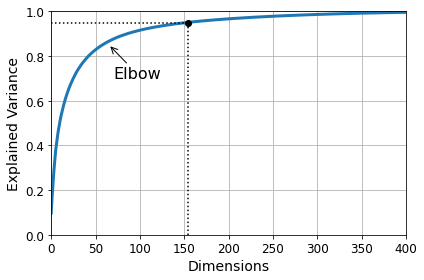

In [25]:
# 설명된 분산을 차원 수에 대한 함수로 그리기
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

### 8.3.7 압축을 위한 PCA
+ 차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어듬(위의 예시에서 대부분의 분산은 유지되었지만 데이터셋은 원본 크기의 20% 미만)
+ PCA 투영의 변환을 반대로 적용해 784차원으로 되돌릴 수 있음(but 일부 손실로 인해 원본 데이터셋을 얻을 수는 없음)

**재구성 오차(reconstruction error)** : 원본 데이터와 재구성된 데이터(압축 후 복원한 것) 사이의 평균 제곱 거리

In [26]:
# MNIST 데이터셋을 154차원으로 압축하고 inverse_transform() 메서드를 사용해 784차원으로 복원
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

이미지 품질이 조금 손실되었지만 숫자 모양은 거의 온전한 상태

<img src="img/8-9.png" width="500px" align='left'>

### 8.3.8 랜덤 PCA
**랜덤 PCA(randomized PCA)** : 확률적 알고리즘을 통해 처음 d개의 주성분에 대한 근삿값을 빠르게 찾음
+ svd_solver : 'randomized'로 지정
+ svd_solver의 기본값은 'auto'  
(m이나 n이 500보다 크고 d가 m이나 n의 80%보다 작으면 사이킷런은 자동으로 랜덤 PCA 알고리즘을 사용)

In [27]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### 8.3.9 점진적 PCA
PCA 구현의 문제점 : SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것

**점진적 PCA(incremental PCA, IPCA)** : 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입
+ IncrementalPCA 파이썬 클래스
+ 전체 훈련 세트를 사용하는 fit() 메서드가 아니라 partial_fit() 메서드를 미니배치마다 호출
+ 특정 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결할 수 있음

In [28]:
# MNIST 데이터셋을 100개의 미니배치로 나누고 사이킷런의 IncrementalPCA를 사용해 차원을 154로 줄임
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

## 8.4 커널 PCA

+ **커널 트릭** : 샘플을 매우 높은 고차원 공간으로 암묵적으로 매핑하여 서포트 벡터 머신의 비선형 분류와 회귀를 가능하게 하는 수학적 기법
+ 고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 복잡한 비선형 결정 경계에 해당함

**커널 PCA(kernel PCA, kPCA)** : 실제로 고차원 공간으로 데이터를 옮기지 않고 마치 그런 효과를 내는 듯한 수학적 트리를 이용해 고차원에 있는 데이터셋을 PCA를 사용해 저차원으로 바꾸는 트릭
+ 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 떄 유용

In [29]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [30]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

그림 저장 kernel_pca_plot


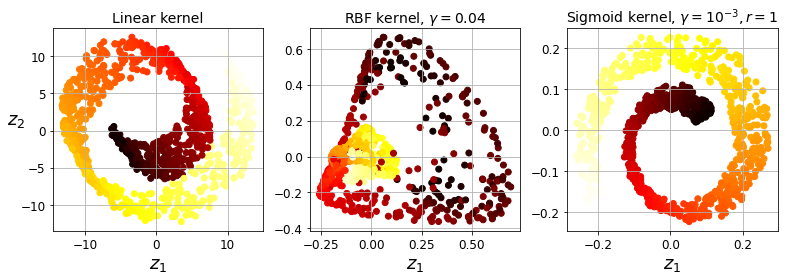

In [31]:
# 여러 가지 커널의 kPCA를 사용해 2D로 축소시킨 스위스 롤
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝
+ kPCA는 비지도 학습이기에 명확한 성능 측정 기준이 없음
+ 차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택 가능
+ best_params_ : 가장 좋은 커널과 하이퍼파라미터 저장

In [32]:
# kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용
# GridSearCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾음
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [33]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있지만, 재구성이 어려움

왼쪽 위 : 스위스 롤의 원본 3D 데이터셋  
오른쪽 위 : RBF 커널의 kPCA를 적용한 2D 데이터셋  
= 특성 맵(feature map)을 사용해 훈련 세트를 무한 차원의 특성 공간에 매핑한 다음, 변환된 데이터셋을 선형 PCA를 사용해 2D로 투영

**재구성 원상(pre-image)** : 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트
+ 원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정 가능
+ 재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터를 선택

<img src="img/8-11.png" width="500px" align='left'>

**재구성 방법**
+ 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련
+ fit_inverse_transform = True로 지정
+ kernelPCA는 fit_inverse_transform = False가 기본, inverse_transform() 메서드를 가지고 있지 않음
    + kernelPCA는 원본 데이터셋을 고차원 공간으로 변횐하지 않고 마치 변환한 것처럼 사용하고 있기에 사실 되돌릴 것이 없음

In [34]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [35]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

## 8.5 LLE

**지역 선형 임베딩(locally linear embedding, LLE)** : 강력한 비선형 차원 축소 기술(NLDR)로 투영에 의존하지 않는 매니폴드 학습
+ 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어 있는지 측정
+ 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾음
+ 잡음이 너무 많지 않은 꼬인 매니폴드를 펼치는 데 잘 작동

In [36]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [37]:
# 사이킷런의 LocallyLinearEmbedding을 사용해 스위스 롤을 펼침
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

그림 저장 lle_unrolling_plot


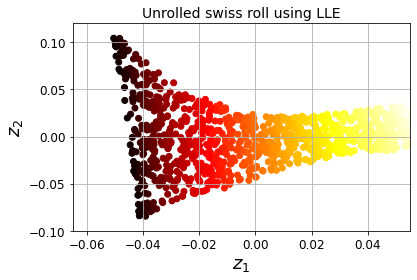

In [38]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

+ 스위스 롤이 완전히 펼쳐졌고 지역적으로는 샘플 간 거리가 잘 보존되어 있음
+ but, 크게 보면 샘플 간 거리가 잘 유지되어 있지 않음
+ LLE는 매니폴드를 모델링하는 데 잘 동작

## 8.6 다른 차원 축소 기법

<img src="img/8-13.png" width="500px" align='left'>

**랜덤 투영(random projection)** : 랜덤한 선형 투영을 사용해 데이터를 저차원 공간으로 투영
+ 랜덤 투영이 실제로 거리를 잘 보존
+ 차원 축소 품질은 샘플 수와 목표 차원수에 따라 다름

**다차원 스케일링(multidimensional scaling, MDS)** : 샘플 간의 거리를 보존하면서 차원을 축소

In [39]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

**Isomap** : 각 샘플을 가장 가까운 이웃과 연결하는 식(샘플 간의 지오데식 거리를 유지하면서 차원 축소)

In [40]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

**t-SNE(t-distributed stochastic neighbor embedding)** : 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소
+ 주로 시각화에 많이 사용
+ 고차원 공간에 있는 샘플의 군집을 시각화할 때 사용

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

C:\Users\jwshi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jwshi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


**선형 판별 분석(linear discriminant analysis(LDA)** : 분류 알고리즘으로 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습
+ 해당 축을 데이터가 투영되는 초평면을 정의하는 데 사용가능
+ 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 분류 알고리즘을 적용하기 전의 차원 축소에 좋음

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)